In [132]:
# !conda install -y catboost tensorflow

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - catboost
    - tensorflow


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    abseil-cpp-20211102.0      |       h93e1e8c_2          13 KB  conda-forge
    absl-py-1.2.0              |     pyhd8ed1ab_0          94 KB  conda-forge
    aiohttp-3.8.3              |  py310h5764c6d_0         449 KB  conda-forge
    aiosignal-1.2.0            |     pyhd8ed1ab_0          12 KB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_0          15 KB  conda-forge
    async-timeout-4.0.2        |     pyhd8ed1ab_0           9 KB  conda-forge
    ca-certificates-2022.9.24  |       ha878542_0         150 KB  conda-forge
    cachetools-5.2.0           |     pyhd8ed1ab_0        

In [158]:
import os

from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from catboost.utils import get_confusion_matrix
import numpy as np
import pandas as pd
import psycopg2
import shap
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb

In [3]:
np.set_printoptions(suppress=True)

In [49]:
with psycopg2.connect(user='daan', password=os.environ['JUPYTER_TOKEN'], host='pg', port=5432, dbname='phishing_data') as cx:
    data = pd.read_sql_query('select * from full_dataset', cx)

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


In [50]:
constant_features = [data.columns.get_loc(x) for x in data.nunique()[(data.nunique()==1)].index.to_list()]

In [52]:
constant_feature_names = data.columns[constant_features].to_list()

In [53]:
# drop features that are constant
data.drop(constant_feature_names, axis=1, inplace=True)

In [54]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [55]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.phishing, random_state=42)

## XGBoost

In [56]:
# https://xgboost.readthedocs.io/en/stable/python/python_intro.html
clf = xgb.XGBClassifier(tree_method='hist', enable_categorical=True, max_cat_to_onehot=3)

In [57]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=3,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [58]:
print(classification_report(clf.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43597
           1       0.97      0.98      0.97     22888

    accuracy                           0.98     66485
   macro avg       0.98      0.98      0.98     66485
weighted avg       0.98      0.98      0.98     66485



In [59]:
print(classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     14467
           1       0.96      0.95      0.95      7695

    accuracy                           0.97     22162
   macro avg       0.97      0.96      0.96     22162
weighted avg       0.97      0.97      0.97     22162



In [60]:
clf.predict_proba(X_test.sample(1))

array([[0.99966675, 0.00033328]], dtype=float32)

In [61]:
clf.predict_proba(X_test.sample(10))

array([[0.02018064, 0.97981936],
       [0.01574415, 0.98425585],
       [0.01420373, 0.9857963 ],
       [0.0069499 , 0.9930501 ],
       [0.9999898 , 0.00001018],
       [0.993915  , 0.006085  ],
       [0.9896838 , 0.0103162 ],
       [0.99982506, 0.00017495],
       [0.9999049 , 0.00009514],
       [0.00697857, 0.9930214 ]], dtype=float32)

In [62]:
clf.save_model('../models/xgb.json')

## CatBoost

In [63]:
cat_features = [X_train.columns.get_loc(x) for x in X_train.nunique()[(X_train.nunique()<3)].index.to_list()]
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [64]:
catboost_model = CatBoostClassifier(iterations=250,
                                    depth=10,
                                    learning_rate=1e-1,
                                    eval_metric='F1'
                                   )

In [65]:
catboost_model.fit(train_pool)

0:	learn: 0.8949237	total: 51.3ms	remaining: 12.8s
1:	learn: 0.9038120	total: 99.1ms	remaining: 12.3s
2:	learn: 0.9143085	total: 152ms	remaining: 12.5s
3:	learn: 0.9192387	total: 204ms	remaining: 12.6s
4:	learn: 0.9205643	total: 253ms	remaining: 12.4s
5:	learn: 0.9250478	total: 307ms	remaining: 12.5s
6:	learn: 0.9266708	total: 355ms	remaining: 12.3s
7:	learn: 0.9280310	total: 402ms	remaining: 12.2s
8:	learn: 0.9288752	total: 450ms	remaining: 12s
9:	learn: 0.9309655	total: 500ms	remaining: 12s
10:	learn: 0.9324348	total: 552ms	remaining: 12s
11:	learn: 0.9328625	total: 599ms	remaining: 11.9s
12:	learn: 0.9332528	total: 655ms	remaining: 11.9s
13:	learn: 0.9344283	total: 711ms	remaining: 12s
14:	learn: 0.9352325	total: 760ms	remaining: 11.9s
15:	learn: 0.9357556	total: 820ms	remaining: 12s
16:	learn: 0.9365847	total: 869ms	remaining: 11.9s
17:	learn: 0.9372732	total: 919ms	remaining: 11.8s
18:	learn: 0.9373191	total: 969ms	remaining: 11.8s
19:	learn: 0.9384183	total: 1.02s	remaining: 11.7

In [107]:
print(classification_report(y_train, catboost_model.predict(train_pool)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     43504
           1       0.98      0.98      0.98     22981

    accuracy                           0.99     66485
   macro avg       0.99      0.98      0.99     66485
weighted avg       0.99      0.99      0.99     66485



In [108]:
print(classification_report(y_test, catboost_model.predict(test_pool)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14496
           1       0.96      0.96      0.96      7666

    accuracy                           0.97     22162
   macro avg       0.97      0.97      0.97     22162
weighted avg       0.97      0.97      0.97     22162



## Logistic Regression

In [74]:
cat_feature_names = X_train.columns[cat_features]
numeric_feature_names = X_train.columns.difference(cat_feature_names)

In [127]:
numeric_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder()

transform = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, [X_train.columns.get_loc(x) for x in numeric_feature_names]),
    ('categorical', cat_transformer, [X_train.columns.get_loc(x) for x in cat_feature_names])
])

pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', LogisticRegression(C=10, max_iter=1000, n_jobs=-1, solver='sag')) 
])

In [128]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 LogisticRegression(C=10, max_iter=1000, n_jobs=-1,
                                    solver='sag'))])

In [129]:
print(classification_report(pipe.predict(X_train), y_train))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     42842
           1       0.92      0.89      0.90     23643

    accuracy                           0.93     66485
   macro avg       0.93      0.92      0.93     66485
weighted avg       0.93      0.93      0.93     66485



In [130]:
print(classification_report(pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14270
           1       0.91      0.89      0.90      7892

    accuracy                           0.93     22162
   macro avg       0.93      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



## Neural Network

In [169]:
# https://gist.github.com/MaxHalford/9bfaa8daf8b4bc17a7fb7ba58c880675
input_dim = len(pipe.named_steps['transform'].get_feature_names_out())
def nn_model():
    model = tf.keras.models.Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [170]:
nn_pipe = Pipeline(steps=[
    ('transform', transform),
    ('predict', KerasClassifier(build_fn=nn_model, batch_size=32, nb_epoch=100,
                               validation_split=0.2, callbacks=[early_stopping])) 
])

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [171]:
nn_pipe.fit(X_train, y_train)

1663/1663 [==============================] - 3s 2ms/step - loss: 0.2272 - accuracy: 0.9062 - val_loss: 0.1734 - val_accuracy: 0.9349


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('numeric', MinMaxScaler(),
                                                  [86, 44, 96, 24, 85, 62, 18,
                                                   80, 34, 52, 70, 7, 40, 58,
                                                   76, 13, 33, 51, 69, 6, 38,
                                                   56, 74, 11, 42, 78, 15, 27,
                                                   19, 45, ...]),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  [22, 25, 26, 31, 41, 48, 49,
                                                   59, 60, 77, 83, 93, 97])])),
                ('predict',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7ff37c293bb0>)])

In [172]:
print(classification_report(nn_pipe.predict(X_train), y_train))

2078/2078 [==============================] - 2s 786us/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     43212
           1       0.91      0.90      0.90     23273

    accuracy                           0.93     66485
   macro avg       0.93      0.92      0.92     66485
weighted avg       0.93      0.93      0.93     66485



In [173]:
print(classification_report(nn_pipe.predict(X_test), y_test))

693/693 [==============================] - 1s 805us/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     14390
           1       0.90      0.89      0.90      7772

    accuracy                           0.93     22162
   macro avg       0.92      0.92      0.92     22162
weighted avg       0.93      0.93      0.93     22162



## SHAP Explainability

In [109]:
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
preds = clf.predict(X_test)
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


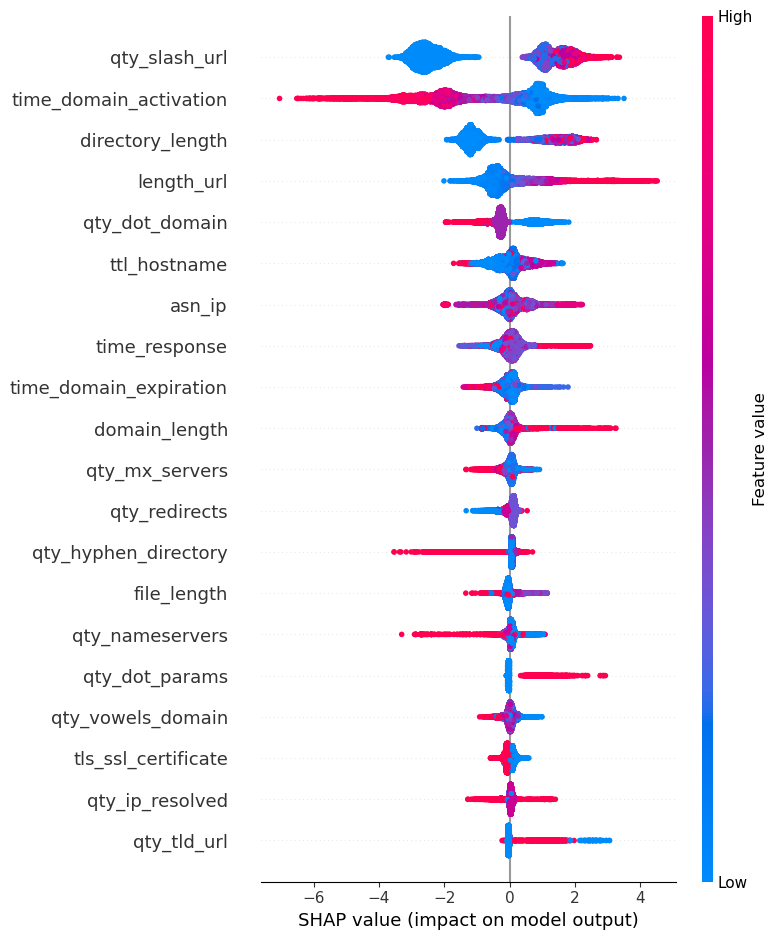

In [110]:
shap.summary_plot(shap_values, X_test)

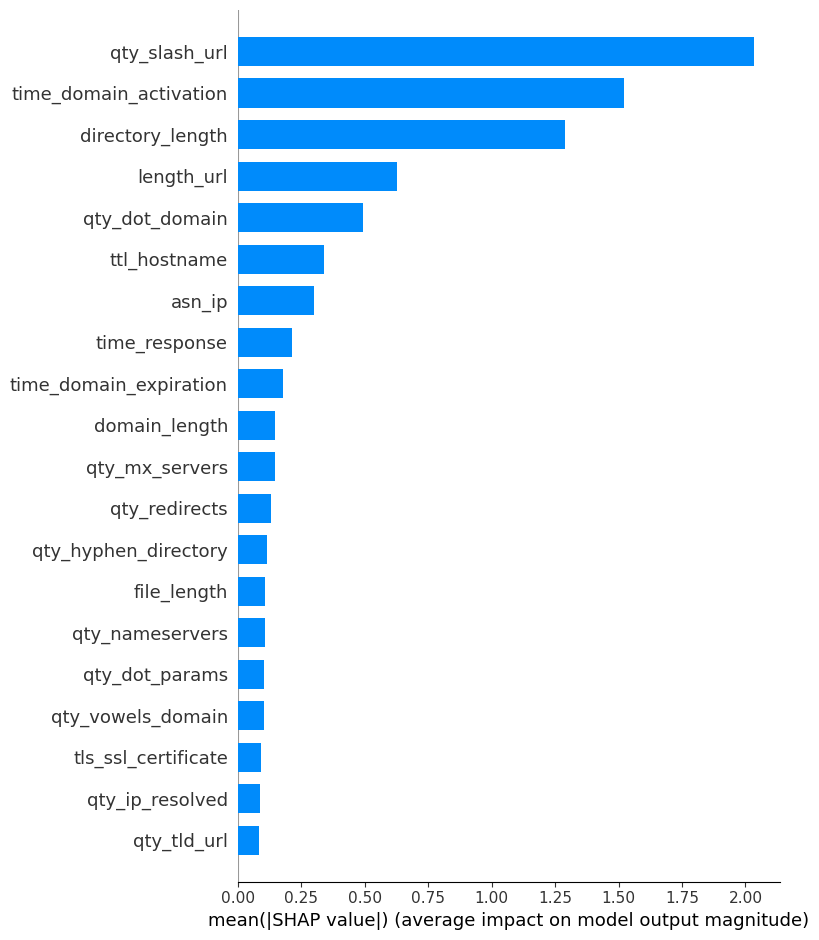

In [111]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [112]:
shap.initjs()

In [113]:
shap.force_plot(exp.expected_value, shap_values[2,:], X_test.iloc[2,:])